In [143]:
import torch
import torch.nn as nn
import torch.optim as optim

device = torch.device("mps")


# Define the neural network
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(1, 50)
        
        self.fc2 = nn.Linear(50, 50)
        self.fc3 = nn.Linear(50, 1)

        self.fcD = nn.Linear(1, 50)
        self.D = nn.Parameter(torch.tensor([1.0]))  # initialize D to 1
        

    def forward(self, x):
        fbc = torch.sin(torch.pi * x)
        x = torch.sigmoid(self.fc1(x) + self.fcD(self.D) )
        x = torch.sigmoid(self.fc2(x))
        u = self.fc3(x) * fbc
        return u


def print_statistics(epoch, **losses):
    """
    Prints the epoch number and an arbitrary number of loss values.

    Args:
        epoch (int): The current epoch number.
        **losses (dict): A dictionary where the keys are descriptive names of the loss values,
                         and the values are the loss values themselves.
    """
    loss_strs = ', '.join(f'{name}: {value:.3g}' for name, value in losses.items())
    print(f'Epoch {epoch}, {loss_strs}')

In [162]:
# exact solution
p = 2
D_ext = 2

def u_exact(x):
    return torch.sin(torch.pi * p * x) / D_ext

def u_init(x):
    return torch.sin(torch.pi * p * x) 

# Known function f
def f(x):
    return - (torch.pi*p)**2 * torch.sin(torch.pi * p * x)


# define residual
def residual(net, x, D):
    u_pred = net(x)
    u_x = torch.autograd.grad(u_pred, x, create_graph=True, retain_graph=True, grad_outputs=torch.ones_like(u_pred))[0]
    u_xx = torch.autograd.grad(u_x, x, create_graph=True,retain_graph=True, grad_outputs=torch.ones_like(u_x))[0]
    res = D * u_xx - f(x)

    # differntiate res w.r.t. D
    res_D = torch.autograd.grad(res, net.D, create_graph=True, grad_outputs=torch.ones_like(res))[0]
    return res, res_D, u_pred

# define mse
def mse(x, y = 0):
    return torch.mean((x - y)**2)


In [145]:

# Create the neural network and move it to GPU
net = Net().to(device)

# Create two separate optimizers with different learning rates
param_net = [param for param in net.parameters() if param is not net.D]
param_pde = [net.D]
optimizer_net = optim.Adam(param_net, lr=0.001)  # Exclude D



x_train_res = torch.linspace(0, 1, 20).view(-1, 1).to(device)
x_train_res.requires_grad_(True)

# Tolerance and maximum iterations
tolerance = 1e-2
maxi_iter = 100000


# Training loop
epoch = 0
while True:  # Change to a while loop to allow for early termination
    # Zero the gradients
    optimizer_net.zero_grad()
    
    res, res_D, u_pred = residual(net, x_train_res, net.D)
    # Forward pass
    val_loss_res = mse(res)
    val_loss_data = mse(u_pred, u_init(x_train_res))
    val_loss_D = mse(res_D)
    
    val_loss_total = val_loss_res + val_loss_data + val_loss_D
        
    # Backward pass
    grads_net = torch.autograd.grad(val_loss_total, param_net, create_graph=True,allow_unused=True)
    
    for param, grad in zip(param_net, grads_net):
        param.grad = grad
    # Step the optimizers
    optimizer_net.step()
    # optimizer_D.step()

    # Output loss values up to three significant digits
    if epoch % 100 == 0:
        print(f'Epoch {epoch}, PDE Loss: {val_loss_res.item():.3g}, Data Loss: {val_loss_data.item():.3g} Total Loss: {val_loss_total.item():.3g} D loss: {val_loss_D.item():.3g} D: {net.D.item():.3g}')

    # Termination conditions
    if val_loss_total.item() < tolerance or epoch >= maxi_iter:
        break  # Exit the loop if loss is below tolerance or maximum iterations reached

    epoch += 1  # Increment the epoch counter

Epoch 0, PDE Loss: 81.6, Data Loss: 0.838 Total Loss: 1.7e+03 D loss: 1.61e+03 D: 1
Epoch 100, PDE Loss: 44.7, Data Loss: 0.459 Total Loss: 45.5 D loss: 0.306 D: 1
Epoch 200, PDE Loss: 43.6, Data Loss: 0.447 Total Loss: 44.2 D loss: 0.142 D: 1
Epoch 300, PDE Loss: 41.5, Data Loss: 0.426 Total Loss: 42 D loss: 0.138 D: 1
Epoch 400, PDE Loss: 38.2, Data Loss: 0.392 Total Loss: 38.7 D loss: 0.128 D: 1
Epoch 500, PDE Loss: 33.2, Data Loss: 0.341 Total Loss: 33.6 D loss: 0.111 D: 1
Epoch 600, PDE Loss: 26.8, Data Loss: 0.275 Total Loss: 27.1 D loss: 0.087 D: 1
Epoch 700, PDE Loss: 19.9, Data Loss: 0.203 Total Loss: 20.1 D loss: 0.0604 D: 1
Epoch 800, PDE Loss: 13.4, Data Loss: 0.136 Total Loss: 13.6 D loss: 0.0369 D: 1
Epoch 900, PDE Loss: 8.07, Data Loss: 0.0816 Total Loss: 8.17 D loss: 0.0199 D: 1
Epoch 1000, PDE Loss: 4.26, Data Loss: 0.0428 Total Loss: 4.32 D loss: 0.00938 D: 1
Epoch 1100, PDE Loss: 1.95, Data Loss: 0.0195 Total Loss: 1.98 D loss: 0.00389 D: 1
Epoch 1200, PDE Loss: 0.77

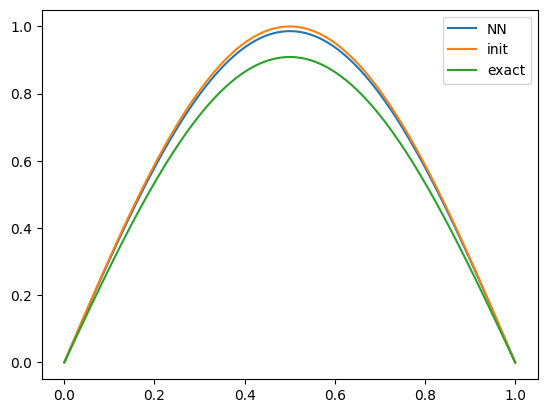

In [148]:
# Evaluate the trained neural network on a new grid
x_test = torch.linspace(0, 1, 100).view(-1, 1).to(device)

# set net.D
with torch.no_grad():
    net.D.data = torch.tensor([1.0]).to(device)

u_test = net(x_test)
u_init_test = u_init(x_test)
u_exact_test = u_exact(x_test)


# visualize the results
import matplotlib.pyplot as plt
plt.figure()

plt.plot(x_test.cpu().numpy(), u_test.cpu().detach().numpy(), label='NN')
plt.plot(x_test.cpu().numpy(), u_init_test.cpu().numpy(), label='init')
plt.plot(x_test.cpu().numpy(), u_exact_test.cpu().numpy(), label='exact')
plt.legend(loc="upper right")


In [149]:
torch.save(net.state_dict(), 'model_weights.pth')

In [160]:
net.load_state_dict(torch.load('model_weights.pth'))
net.to(device)

Net(
  (fc1): Linear(in_features=1, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=50, bias=True)
  (fc3): Linear(in_features=50, out_features=1, bias=True)
  (fcD): Linear(in_features=1, out_features=50, bias=True)
)

In [163]:
tolerance = 1e-3
optimizer_D = optim.Adam(param_pde, lr=0.0001)  # Only D
# Training loop
epoch = 0
while True:  # Change to a while loop to allow for early termination
    # Zero the gradients
    optimizer_net.zero_grad()
    optimizer_D.zero_grad()
    
    # Forward pass
    res, res_D, u_pred = residual(net, x_train_res, net.D)
    # Forward pass
    val_loss_res = mse(res)
    val_loss_data = mse(u_pred, u_exact(x_train_res))
    val_loss_D = mse(res_D)
    
    val_loss_total = val_loss_res + val_loss_data + val_loss_D

    
    # Backward pass
    grads_net = torch.autograd.grad(val_loss_res + val_loss_D, param_net, create_graph=True, allow_unused=True)
    grads_pdeparam = torch.autograd.grad(val_loss_data, param_pde, create_graph=True, allow_unused=True)
    
    for param, grad in zip(param_net, grads_net):
        param.grad = grad
    
    for param, grad in zip(param_pde, grads_pdeparam):
        param.grad = grad

    # Step the optimizers
    optimizer_net.step()
    optimizer_D.step()

    # Output loss values up to three significant digits
    if epoch % 100 == 0:
        print_statistics(epoch, PDE=val_loss_res, Data=val_loss_data, Dloss=val_loss_D, Total=val_loss_total, D=net.D.item())

    # Termination conditions
    if val_loss_total.item() < tolerance or epoch >= maxi_iter:
        break  # Exit the loop if loss is below tolerance or maximum iterations reached

    epoch += 1  # Increment the epoch counter



Epoch 0, PDE: 0.000769, Data: 0.0868, Dloss: 0.000505, Total: 0.0881, D: 1.08
Epoch 100, PDE: 0.00239, Data: 0.0849, Dloss: 2.54e-06, Total: 0.0873, D: 1.09
Epoch 200, PDE: 0.0022, Data: 0.0815, Dloss: 1.81e-05, Total: 0.0837, D: 1.1
Epoch 300, PDE: 0.00206, Data: 0.0783, Dloss: 0.00144, Total: 0.0818, D: 1.11
Epoch 400, PDE: 0.0017, Data: 0.0752, Dloss: 7.88e-06, Total: 0.0769, D: 1.12
Epoch 500, PDE: 0.00145, Data: 0.0722, Dloss: 0.000354, Total: 0.074, D: 1.13
Epoch 600, PDE: 0.00136, Data: 0.0695, Dloss: 7.25e-06, Total: 0.0709, D: 1.14
Epoch 700, PDE: 0.00116, Data: 0.0669, Dloss: 0.000435, Total: 0.0685, D: 1.15
Epoch 800, PDE: 0.00115, Data: 0.0645, Dloss: 0.000203, Total: 0.0659, D: 1.16
Epoch 900, PDE: 0.00104, Data: 0.0621, Dloss: 2.85e-07, Total: 0.0632, D: 1.16
Epoch 1000, PDE: 0.000651, Data: 0.0595, Dloss: 0.018, Total: 0.0782, D: 1.17
Epoch 1100, PDE: 0.000902, Data: 0.0578, Dloss: 6.53e-06, Total: 0.0587, D: 1.18
Epoch 1200, PDE: 0.00068, Data: 0.0556, Dloss: 0.00391, T

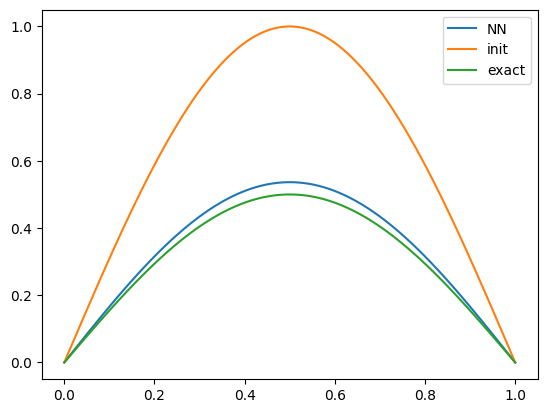

In [164]:
# Evaluate the trained neural network on a new grid
x_test = torch.linspace(0, 1, 100).view(-1, 1).to(device)

u_test = net(x_test)
u_init_test = u_init(x_test)
u_exact_test = u_exact(x_test)


# visualize the results
import matplotlib.pyplot as plt
plt.figure()

plt.plot(x_test.cpu().numpy(), u_test.cpu().detach().numpy(), label='NN')
plt.plot(x_test.cpu().numpy(), u_init_test.cpu().numpy(), label='init')
plt.plot(x_test.cpu().numpy(), u_exact_test.cpu().numpy(), label='exact')
plt.legend(loc="upper right")
